In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn import preprocessing
import statsmodels.api as sm
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.datasets import load_diabetes
from statsmodels.multivariate.pca import PCA # PCR

In [2]:
data_diabetes = load_diabetes(scaled=False)
data_diabetes

{'data': array([[59.    ,  2.    , 32.1   , ...,  4.    ,  4.8598, 87.    ],
        [48.    ,  1.    , 21.6   , ...,  3.    ,  3.8918, 69.    ],
        [72.    ,  2.    , 30.5   , ...,  4.    ,  4.6728, 85.    ],
        ...,
        [60.    ,  2.    , 24.9   , ...,  3.77  ,  4.1271, 95.    ],
        [36.    ,  1.    , 30.    , ...,  4.79  ,  5.1299, 85.    ],
        [36.    ,  1.    , 19.6   , ...,  3.    ,  4.5951, 92.    ]]),
 'target': array([151.,  75., 141., 206., 135.,  97., 138.,  63., 110., 310., 101.,
         69., 179., 185., 118., 171., 166., 144.,  97., 168.,  68.,  49.,
         68., 245., 184., 202., 137.,  85., 131., 283., 129.,  59., 341.,
         87.,  65., 102., 265., 276., 252.,  90., 100.,  55.,  61.,  92.,
        259.,  53., 190., 142.,  75., 142., 155., 225.,  59., 104., 182.,
        128.,  52.,  37., 170., 170.,  61., 144.,  52., 128.,  71., 163.,
        150.,  97., 160., 178.,  48., 270., 202., 111.,  85.,  42., 170.,
        200., 252., 113., 143.,  51

In [3]:
data = data_diabetes['data']
target = data_diabetes['target']
feature_names = data_diabetes['feature_names']

Data = pd.DataFrame(data, columns=feature_names)
Data['target'] = target

print(Data.head())

    age  sex   bmi     bp     s1     s2    s3   s4      s5    s6  target
0  59.0  2.0  32.1  101.0  157.0   93.2  38.0  4.0  4.8598  87.0   151.0
1  48.0  1.0  21.6   87.0  183.0  103.2  70.0  3.0  3.8918  69.0    75.0
2  72.0  2.0  30.5   93.0  156.0   93.6  41.0  4.0  4.6728  85.0   141.0
3  24.0  1.0  25.3   84.0  198.0  131.4  40.0  5.0  4.8903  89.0   206.0
4  50.0  1.0  23.0  101.0  192.0  125.4  52.0  4.0  4.2905  80.0   135.0


得到样本的特征数量与样本量

In [4]:
p = Data.shape[1] - 1
n = Data.shape[0]

print("The number of features is", p)
print("The sample size is", n)

The number of features is 10
The sample size is 442


# 背景

"Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline."

该数据来自"Least Angle Regression," Annals of Statistics (with discussion), 407-499, Bradley Efron, Trevor Hastie, Iain Johnstone and Robert Tibshirani (2004) 。记录了442名糖尿病患者10项健康指标，以及未来的病情发展情况 

自变量包括age, sex, bmi, bp, s1, s2, s3, s4, s5, s6，相应变量为最后的target

<table center=True>
    <tr>
        <td> 变量名 </td>
        <td> 均值 </td>
        <td> 标准差 </td>
    </tr>
    <tr>
        <td> age </td>
        <td> 48.52</td>
        <td> 13.11</td>
    </tr>
    <tr>
        <td> sex</td>
        <td> 1.47</td>
        <td> 0.50</td>
    </tr>
    <tr>
        <td> bmi</td>
        <td> 26.38</td>
        <td> 4.42</td>
    </tr>
    <tr>
        <td> bp</td>
        <td> 94.65</td>
        <td> 13.83</td>
    </tr>
    <tr>
        <td> s1</td>
        <td> 189.14</td>
        <td> 34.61</td>
    </tr>
    <tr>
        <td> s2</td>
        <td> 115.44</td>
        <td> 30.41</td>
    </tr>
    <tr>
        <td> s3 </td>
        <td> 49.79</td>
        <td> 12.93</td>
    </tr>
    <tr>
        <td> s4 </td>
        <td> 4.07</td>
        <td> 1.29 </td>
    </tr>
    <tr>
        <td> s5</td>
        <td> 4.64 </td>
        <td> 0.52</td>
    </tr>
    <tr>
        <td> s6</td>
        <td> 91.26</td>
        <td> 11.50</td>
    </tr>
    <tr>
        <td> y</td>
        <td> 152.13</td>
        <td> 77.09</td>
    </tr>
</table>

# 模型

## 数据预处理

In [5]:
n_train = int(n * 0.75) # 75% instances used for training
n_test = n-n_train
seed = 438
random.seed(seed)
index = range(0, n)
index_selected = random.sample(index, n_train)
index_selected.sort()

Data_train = Data.loc[index_selected]
Data_test = Data.drop(index = index_selected)

用于建模的数据集

In [6]:
Data_train.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.00,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.00,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.00,4.2905,80.0,135.0
6,36.0,2.0,22.0,90.0,160.0,99.6,50.0,3.00,3.9512,82.0,138.0
7,66.0,2.0,26.2,114.0,255.0,185.0,56.0,4.55,4.2485,92.0,63.0


用于评价的数据集

In [7]:
Data_test.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
5,23.0,1.0,22.6,89.0,139.0,64.8,61.0,2.0,4.1897,68.0,97.0
8,60.0,2.0,32.1,83.0,179.0,119.4,42.0,4.0,4.4773,94.0,110.0
11,56.0,2.0,28.0,85.0,184.0,144.8,32.0,6.0,3.5835,77.0,69.0


除了划分训练集和测试集之外，我们还需要将数据进行预处理。在本次实验中，我们将特征，即自变量，进行**标准化**，而将标签，即响应变量，进行中心化。

In [44]:
## Pre-processing
X_train = Data_train.drop(columns = ['target'], axis = 1)
Y_train = Data_train.target
X_test = Data_test.drop(columns = ["target"], axis=1)
Y_test = Data_test.target

X_train_standardized = preprocessing.scale(X_train, with_mean = True, with_std=True) / np.sqrt(n_train)
Y_train_centered = preprocessing.scale(Y_train, with_mean = True, with_std=False)
Y_train_mean = np.average(Y_train)
X_test_standardized = preprocessing.scale(X_test, with_mean = True, with_std=True) / np.sqrt(n_test)
Y_test_mean = np.average(Y_test)

建立一个线性模型

In [9]:
X_train_withintercept = sm.add_constant(X_train)
model = sm.OLS(Y_train,X_train_withintercept).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     31.67
Date:                Thu, 02 Nov 2023   Prob (F-statistic):           2.82e-42
Time:                        08:41:59   Log-Likelihood:                -1794.1
No. Observations:                 331   AIC:                             3610.
Df Residuals:                     320   BIC:                             3652.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -318.2494     80.933     -3.932      0.000    -477.477    -159.022
age           -0.2149      0.255     -0.844      0.399      -0.716       0.286
sex          -18.4485      6.768     -2.726      0.007     -31.763      -5.134
bmi            4.7990      0.853      5.625      0.000       3.121       6.477
bp             1.0447      0.277      3.772      0.000       0.500       1.589
s1            -0.7760      0.667     -1.163      0.246      -2.089       0.537
s2             0.5744      0.611      0.940      0.348      -0.628       1.777
s3            -0.0339      0.928     -0.037      0.971      -1.860       1.792
s4             0.5925      7.249      0.082      0.935     -13.670      14.855
s5            70.8602     18.379      3.855      0.000      34.700     107.020
s6             0.3737      0.327      1.144      0.254      -0.269       1.017
==============================================================================
Omnibus:                        1.661   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.436   Jarque-Bera (JB):                1.475
Skew:                           0.010   Prob(JB):                        0.478
Kurtosis:                       2.674   Cond. No.                     7.33e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.33e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 判断多重共线性

首先观察特征之间的相关性

<Axes: >

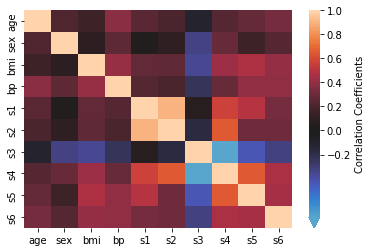

In [10]:
pcorr = X_train.corr(method = 'pearson')
tick_ = (np.arange(0,13,2)-2)/10
dict_ = {"orientation":'vertical',
         'label':'Correlation Coefficients',
         "drawedges":False,
         "ticklocation":"top",
         "extend":"min",
         "alpha":0.8,
         "cmap":"cmap",
         "ticks":tick_}
sns.heatmap(pcorr,cbar_kws= dict_,center=0)

方差扩大因子法

In [11]:
vif_cv = 5

In [12]:
# Method One
C = np.linalg.inv(np.dot(X_train_standardized.T,X_train_standardized))
VIF_1 = np.diag(C)
print("The VIF's are", np.round(VIF_1,2))

The VIF's are [ 1.27  1.22  1.55  1.52 59.39 38.38 15.27  9.4  10.11  1.53]


In [13]:
# Method Two
VIF_2 = [variance_inflation_factor(X_train_standardized[:,0:p], i) for i in range(p)]
print("The VIF's are", np.round(VIF_2,2))

The VIF's are [ 1.27  1.22  1.55  1.52 59.39 38.38 15.27  9.4  10.11  1.53]


In [14]:
# Method Three
X_1 = X_train_standardized[:,0]
X_others = X_train_standardized[:,1:p]
model_vif = sm.OLS(X_1,X_others).fit()
X_1_VIF = 1/(1-model_vif.rsquared)
print("The VIF of the first feature is", np.round(X_1_VIF,2))

The VIF of the first feature is 1.27


可以看到s1, s2, s3, s4, s5变量的多重共线性较为严重

使用矩阵特征值来进行观察

In [15]:
R = np.dot(X_train_standardized.T,X_train_standardized)
W, V = np.linalg.eig(R)
W = -1* np.sort(-1*W)
W_diag = np.diag(W)
V = V.T
print("The eigen values are", np.round(W,4))

The eigen values are [4.0785 1.5295 1.1411 0.9645 0.6611 0.5781 0.4967 0.4659 0.076  0.0086]


In [16]:
Condition_Number = np.sqrt(np.max(W)/np.min(W))
print("The condition number is",np.round(Condition_Number,4))

The condition number is 21.776


可以看到矩阵条件数较大

In [17]:
model_ols = sm.OLS(Y_train_centered,X_train_standardized).fit()
print("The condition number is",round(model_ols.condition_number,4))

The condition number is 21.776


## 构建岭回归模型

In [18]:
## Ridge Regression
alpha  = 0.1 # A hyperparameter in Ridge Regression (equivalently but not equally, k in slides)
model_rr = sm.OLS(Y_train_centered,X_train_standardized).fit_regularized(L1_wt=0,alpha = alpha)
print("The parameters in the ridge regression are ",np.round(model_rr.params,2))

The parameters in the ridge regression are  [  5.97   1.27  21.96  16.7    8.     5.87 -15.2   16.18  22.75  14.4 ]


In [19]:
alpha_num = 100
alpha_vec = np.array(list(range(0,alpha_num)))/alpha_num/1000
RR_coef = []
RR_vif = []

for alpha in alpha_vec:
    rr_model = sm.OLS(Y_train_centered,X_train_standardized).fit_regularized(L1_wt=0,alpha = alpha)
    rr_coef = rr_model.params
    RR_coef.append(rr_coef)

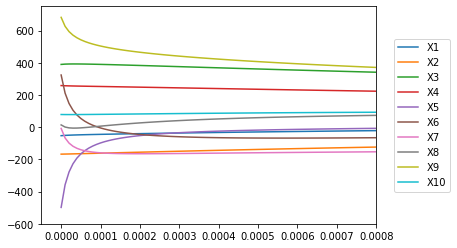

In [20]:
for i in range(p):
    plt.plot(alpha_vec, np.array(RR_coef)[:,i],label = "X%d"%(i+1))

plt.axis([-0.00005, 0.0008, -600, 750])    
plt.legend(loc="right",bbox_to_anchor=(1.25,0.5),borderaxespad=1)

In [21]:
C_k = []
for alpha in alpha_vec:
    k = alpha * n_train
    c_k = np.linalg.inv(X_train_standardized.T @ X_train_standardized + k * np.eye(p)) @ X_train_standardized.T @ X_train_standardized @ np.linalg.inv(X_train_standardized.T @ X_train_standardized + k * np.eye(p))
    C_k.append(np.mean(np.diag(c_k)))

alpha_best = alpha_vec[np.min(np.where(np.array(C_k) < vif_cv))]
print("The chosen value of alpha is", alpha_best)

The chosen value of alpha is 2.9999999999999997e-05


In [22]:
model_rr_best = sm.OLS(Y_train_centered,X_train_standardized).fit_regularized(L1_wt=0,alpha = alpha_best)
model_rr_best_coef = model_rr_best.params

## 主成分回归模型

构建主成分

In [24]:
model_pca = PCA(X_train_standardized,standardize = False, demean = True)
model_pca_cr = model_pca.eigenvals # contribution rate of each component
print("The percentages of total variance are", np.around(model_pca_cr,4))

The percentages of total variance are [4.0785 1.5295 1.1411 0.9645 0.6611 0.5781 0.4967 0.4659 0.076  0.0086]


验证代码

In [25]:
Corr_Mat = X_train_standardized.T @ X_train_standardized
Lambda, V = np.linalg.eig(Corr_Mat)
Lambda = sorted(Lambda,reverse = True)
print("The eigen values of X'X are ", np.around(Lambda,4))

The eigen values of X'X are  [4.0785 1.5295 1.1411 0.9645 0.6611 0.5781 0.4967 0.4659 0.076  0.0086]


绘制scree plot来作出主成分个数的主观判断

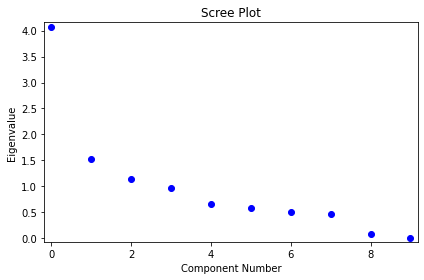

In [26]:
fig = model_pca.plot_scree(log_scale = False)

计算累计贡献率

In [28]:
model_pca_ccr = np.cumsum(model_pca_cr)/p # cummulative contribution rate
print("The cummulative percentages of total variance are", np.around(model_pca_ccr,4))

The cummulative percentages of total variance are [0.4079 0.5608 0.6749 0.7714 0.8375 0.8953 0.945  0.9915 0.9991 1.    ]


使累计贡献率到达85%

In [30]:
pca_cv = 0.85

In [31]:
num_pca = np.min(np.where(model_pca_ccr > pca_cv))
print("The appropriate number of component is", (num_pca+1))

The appropriate number of component is 6


构建新特征

In [35]:
model_pca_selected = PCA(X_train_standardized,  standardize = False,  demean = True)
V = model_pca_selected.loadings
Z_train_standardized= X_train_standardized @ V[:,0:(num_pca+1)]
model_pcr = sm.OLS(Y_train_centered, Z_train_standardized).fit()
model_pcr_coef = V.T @ np.pad(model_pcr.params,(0,p-(num_pca+1)))

# 模型验证

In [47]:
y_std = np.std(Y_test)
print(y_std)

76.60095955209437


### 线性模型

In [40]:
model_ols_coef = model_ols.params 
Y_pred_ols = Y_train_mean + X_test_standardized @ model_ols_coef
ols_rmse = np.sqrt(np.mean((Y_pred_ols-Y_test)**2))
print("The RMSE in the ordinary regression is", round(ols_rmse,4))

The RMSE in the ordinary regression is 59.946


### 岭回归估计

In [45]:
Y_pred_rr = Y_train_mean + X_test_standardized @ model_rr_best_coef
rr_rmse = np.sqrt(np.mean((Y_pred_rr-Y_test)**2))

print("The RMSE in the ridge regression is", round(rr_rmse,4))

The RMSE in the ridge regression is 59.4494


### 主成分回归

In [46]:
Y_pred_pcr = Y_train_mean + X_test_standardized @ model_pcr_coef
pcr_rmse = np.sqrt(np.mean((Y_pred_pcr-Y_test)**2))

print("The RMSE in the principal component regression is", round(pcr_rmse,4))

The RMSE in the principal component regression is 88.9413
